<a href="https://colab.research.google.com/github/GurcanDurukan/google-research/blob/master/tiny_nerf_with_objectron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd Repo

[Errno 2] No such file or directory: 'Repo'
/content


In [2]:
! git clone https://github.com/Fyusion/LLFF.git
%cd llff


Cloning into 'LLFF'...
remote: Enumerating objects: 774, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 774 (delta 7), reused 9 (delta 1), pack-reused 748
Receiving objects: 100% (774/774), 31.94 MiB | 27.91 MiB/s, done.
Resolving deltas: 100% (409/409), done.
[Errno 2] No such file or directory: 'llff'
/content


In [ ]:
from google.colab import output
#I don't know why nbextensions don't work with python3.6 
with output.temporary():
  !pip install --upgrade git+https://github.com/Kreijstal/colab_inspector.git 
  !python2.7 -m pip install --upgrade git+https://github.com/blois/colab_inspector.git #yes, really.
  !jupyter nbextension install --py inspector

import inspector

# open a scratch cell (Ctrl+Alt+N)
# run there
# inspector.watch_globals()

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 1.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


In [ ]:
!git clone https://github.com/google-research-datasets/Objectron.git
%cd Objectron
%cd objectron
!pip install frozendict
!apt install subversion

In [ ]:
! pip install PyWavelets

In [ ]:
import pywt
import pywt.data

from skimage.color import rgba2rgb
from skimage import data

In [ ]:
import glob
import os
import struct
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from matplotlib import image
from mpl_toolkits.mplot3d import art3d
from os import path

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The AR Metadata captured with each frame in the video
from objectron.schema import a_r_capture_metadata_pb2 as ar_metadata_protocol

In [ ]:
video_id = 'shoe/batch-24/33'
download_dir = './nerf_data'

os.makedirs(download_dir, exist_ok=True)
public_url = "https://storage.googleapis.com/objectron"
urls = [f'{public_url}/videos/{video_id}/video.MOV',
        f'{public_url}/videos/{video_id}/geometry.pbdata']
for url in urls:
    with open(path.join(download_dir, path.basename(url)), "wb") as f:
        f.write(requests.get(url).content)



In [ ]:
ls -sh1 ./nerf_data

total 38M
3.7M geometry.pbdata
 34M video.MOV


In [ ]:
%%bash
cd nerf_data/
mkdir -p "images_8"
ffmpeg -i video.MOV -vsync vfr -vf "scale=iw/8:ih/8" -start_number 0 "images_8/%05d.png"

In [ ]:
sequence_filenames = sorted(glob.glob('nerf_data/images_8/*.png'))
geometry_filename = 'nerf_data/geometry.pbdata'

In [ ]:
def load_frame_data(geometry_filename):
    # See get_geometry_data in objectron-geometry-tutorial.ipynb
    frame_data = []
    with open(geometry_filename, 'rb') as pb:
        proto_buf = pb.read()

        i = 0
        while i < len(proto_buf):
            msg_len = struct.unpack('<I', proto_buf[i:i + 4])[0]
            i += 4
            message_buf = proto_buf[i:i + msg_len]
            i += msg_len
            frame = ar_metadata_protocol.ARFrame()
            frame.ParseFromString(message_buf)
            frame_data.append(frame)
    return frame_data

frame_data = load_frame_data(geometry_filename)

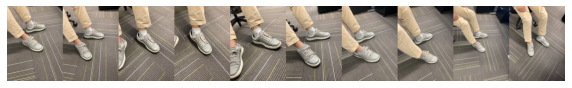

In [ ]:
step = 50

plt.figure(figsize=(10,3))
plt.imshow(np.concatenate([image.imread(filename) for filename in sequence_filenames[::step]], axis=1))
plt.axis('off')
plt.show()
#print(f'{len(sequence_filenames)} PNG files found')

In [ ]:
def make_poses_bounds_array(frame_data, near=0.2, far=10):
    # See https://github.com/Fyusion/LLFF#using-your-own-poses-without-running-colmap
    # Returns an array of shape (N, 17).
    rows = []
    for frame in frame_data:
        camera = frame.camera
        cam_to_world = np.array(camera.transform).reshape(4,4)[:3]
        w = camera.image_resolution_width
        h = camera.image_resolution_height
        assert w>=h, (w, h)  # assume landscape
        # JaxNeRF assumes x,y focal lengths are equal.
        row = llff_pose(cam_to_world, image_hw=[w, h],
                        focal=camera.intrinsics[0], near=near, far=far)
        rows.append(row)
    return np.vstack(rows)

def llff_pose(cam_to_world_mat34, image_hw, focal, near, far):
    # Returns an array of shape (17,).
    col = np.concatenate([image_hw, [focal]]).reshape(-1, 1)
    mat35 = np.hstack([cam_to_world_mat34, col])
    return np.concatenate([mat35.ravel(), [near, far]])

In [ ]:
frame_data = load_frame_data(geometry_filename)
poses = make_poses_bounds_array(frame_data, near=0.2, far=10)
#np.save('nerf_data/poses_bounds.npy', poses)




In [ ]:
poses_new=np.ndarray([110,4,4])

for c1 in range (0,110):

  poses_temp=poses[c1]
  poses_temp=poses_temp.reshape(1,17)

  poses_temp=np.delete(poses_temp,np.argmin(poses_temp))
  poses_temp=poses_temp.reshape(4,4)


  poses_temp[2,0]=0
  poses_temp[3,0]=0
  poses_temp[3,1]=0
  poses_temp[3,2]=0
  #poses_temp[3,3]=1

  poses_temp=poses_temp/10
  poses_temp[3,3]=1

  poses_new[c1]=poses_temp

poses=poses_new




In [ ]:
images=np.ndarray([110,120,90,3])

for c1 in range(0,110):

  image_temp=cv2.imread(sequence_filenames[c1])

  red,green,blue = cv2.split(image_temp)

  coeffs2 = pywt.dwt2(red, 'haar')
  LL_red, (LH, HL, HH) = coeffs2

  coeffs2 = pywt.dwt2(green, 'haar')
  LL_green, (LH, HL, HH) = coeffs2

  coeffs2 = pywt.dwt2(blue, 'haar')
  LL_blue, (LH, HL, HH) = coeffs2

  LL_red=LL_red/2
  LL_green=LL_green/2
  LL_blue=LL_blue/2

  image_temp_ww=cv2.merge((LL_red,LL_green,LL_blue))
  #image_temp_ww=cv2.resize(image_temp_ww,(90,90),interpolation=cv2.INTER_AREA)
  image_temp_ww=image_temp_ww/255

  images[c1]=image_temp_ww



focal=1464/2

(110, 120, 90, 3) (110, 4, 4) 732.0


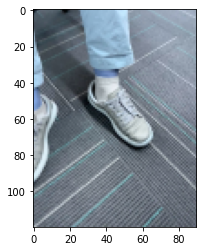

In [ ]:
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)
testimg, testpose = images[105], poses[105]
images = images[:100,...,:3]
poses = poses[:100]
plt.imshow(testimg)
plt.show()


In [ ]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

0 0.07823536872863769 secs per iter


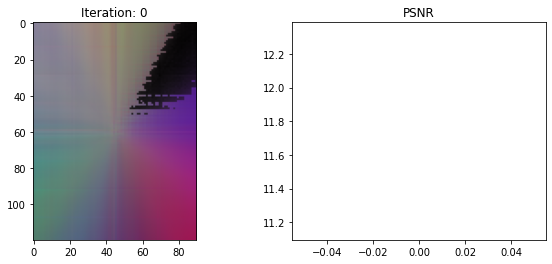

25 1.8918436908721923 secs per iter


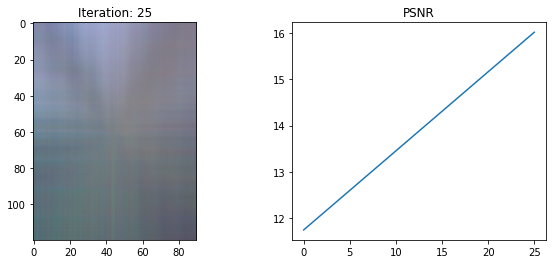

50 1.8839497756958008 secs per iter


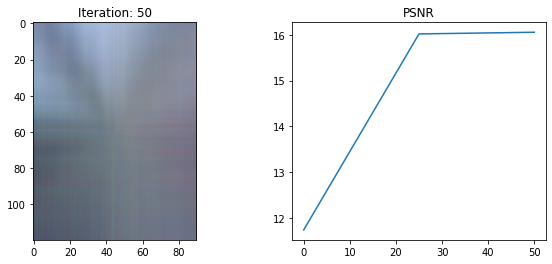

75 1.882658519744873 secs per iter


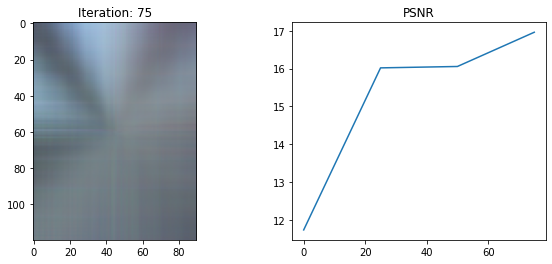

100 1.8789710807800293 secs per iter


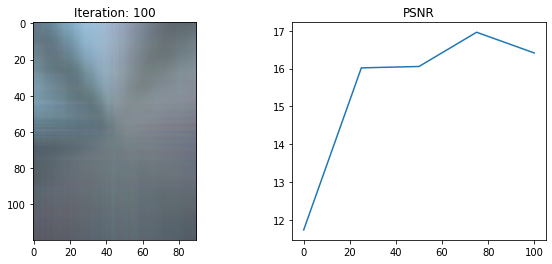

125 1.875471887588501 secs per iter


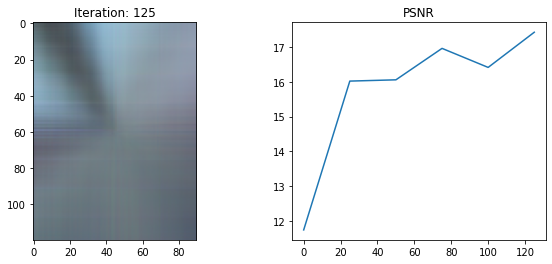

150 1.8711268043518066 secs per iter


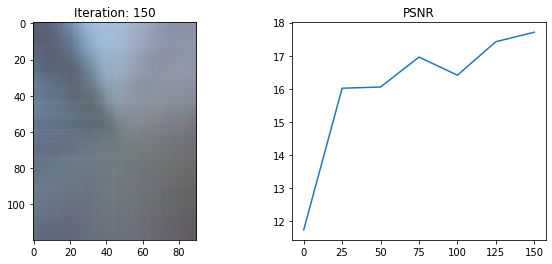

175 1.8697155284881593 secs per iter


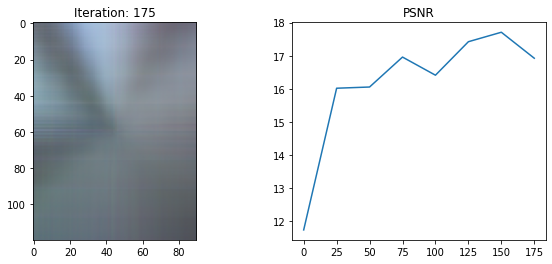

200 1.8751614856719971 secs per iter


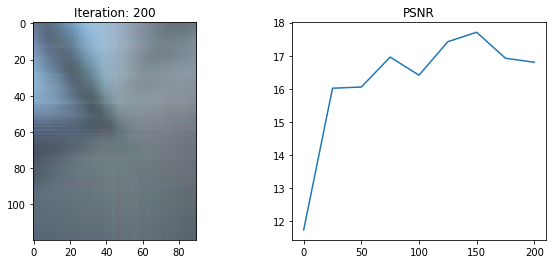

225 1.8724472522735596 secs per iter


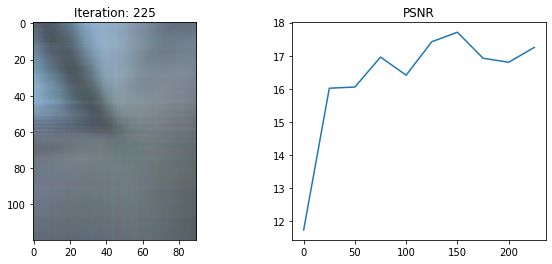

250 1.8777965545654296 secs per iter


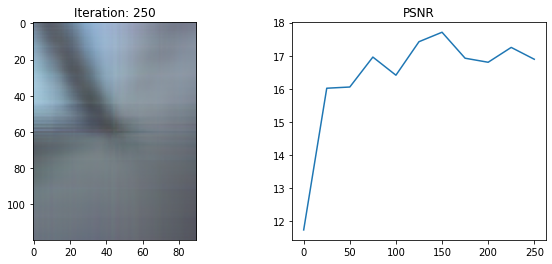

275 1.8809410762786865 secs per iter


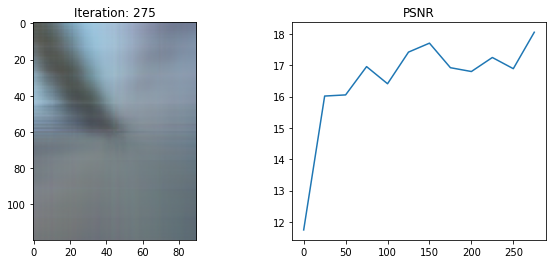

300 1.8789365673065186 secs per iter


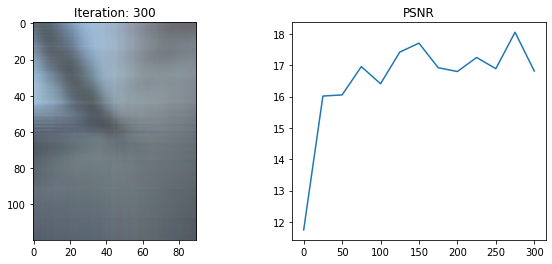

325 1.8785075187683105 secs per iter


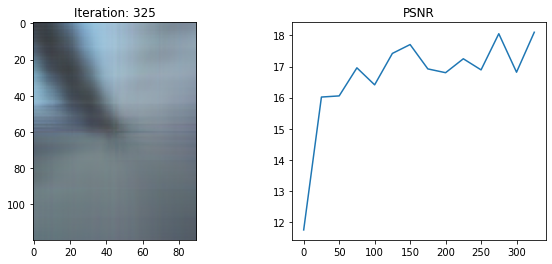

350 1.8783708667755128 secs per iter


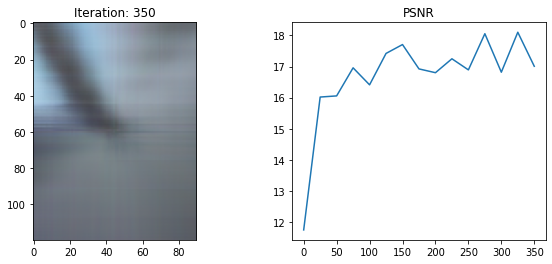

375 1.8864803409576416 secs per iter


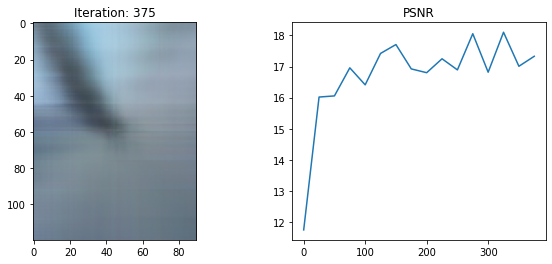

400 1.8803152847290039 secs per iter


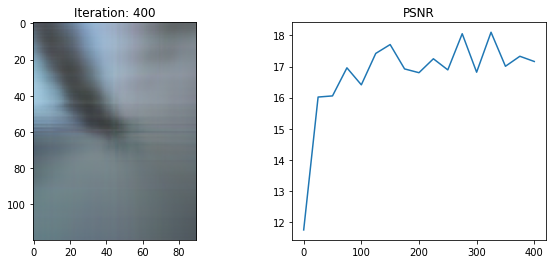

425 1.8791216945648193 secs per iter


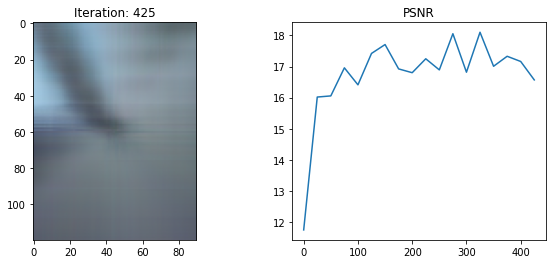

450 1.877856397628784 secs per iter


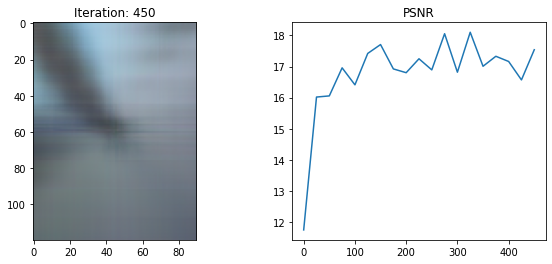

475 1.8773602390289306 secs per iter


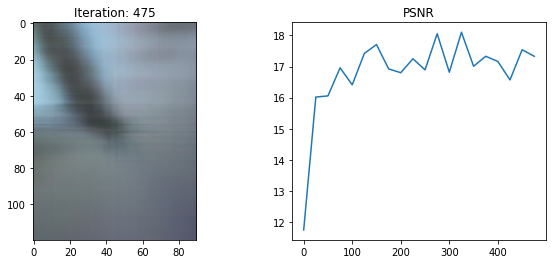

500 1.8753715705871583 secs per iter


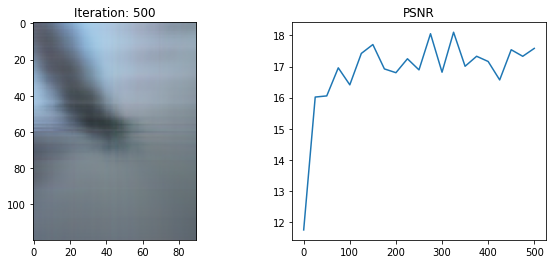

525 1.8719414043426514 secs per iter


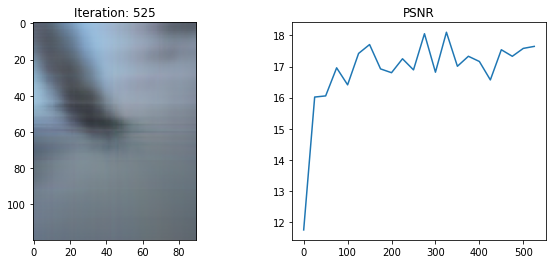

550 1.8684503936767578 secs per iter


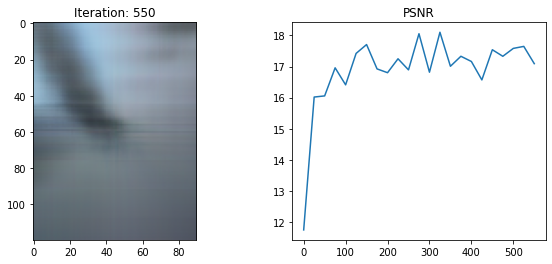

575 1.867701187133789 secs per iter


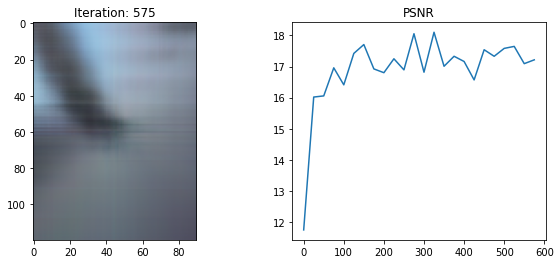

600 1.8673534393310547 secs per iter


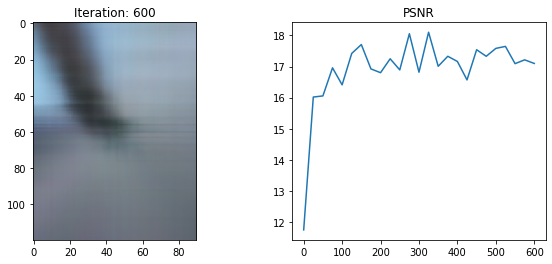

625 1.8666948413848876 secs per iter


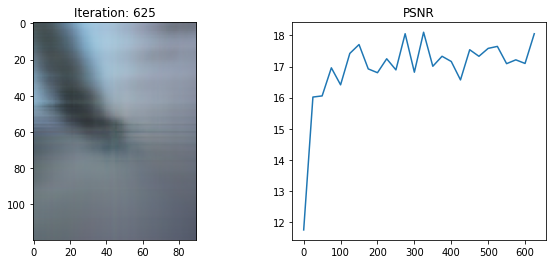

650 1.869156141281128 secs per iter


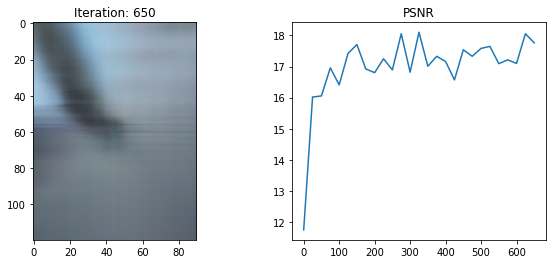

675 1.866992826461792 secs per iter


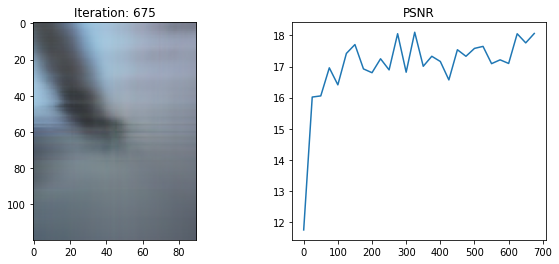

700 1.8686191749572754 secs per iter


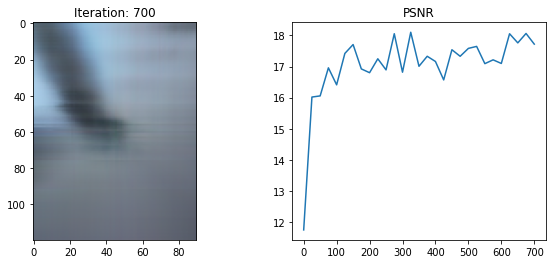

725 1.8676088047027588 secs per iter


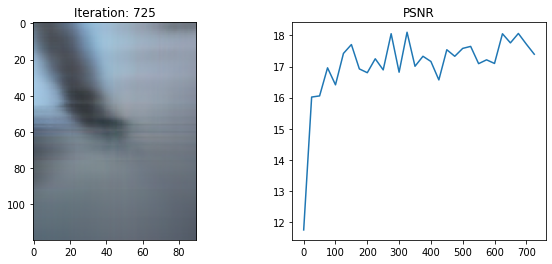

750 1.8753945064544677 secs per iter


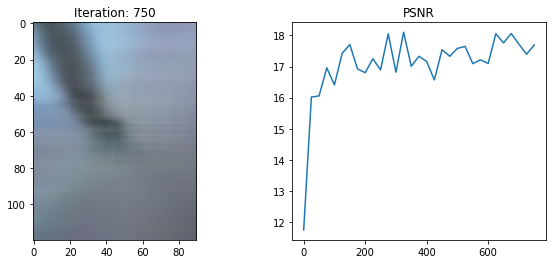

775 1.8664473819732665 secs per iter


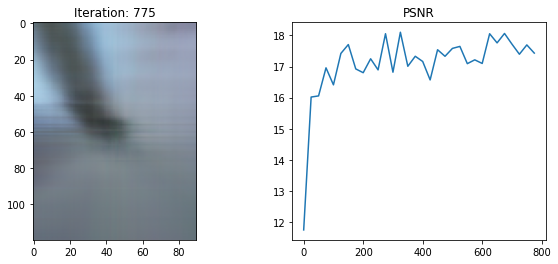

800 1.8667772388458252 secs per iter


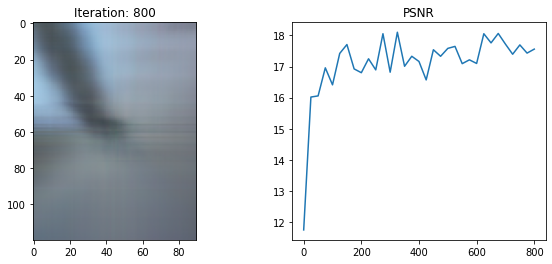

825 1.8686347961425782 secs per iter


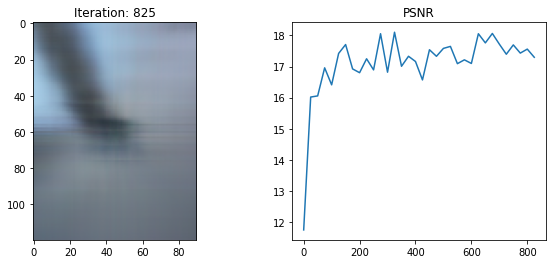

850 1.8673297119140626 secs per iter


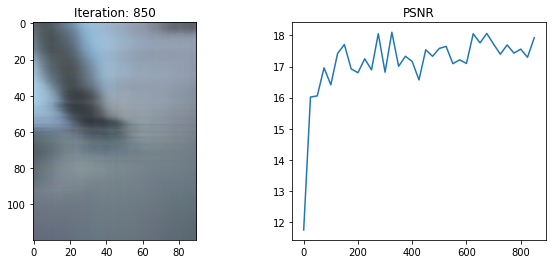

875 1.868383255004883 secs per iter


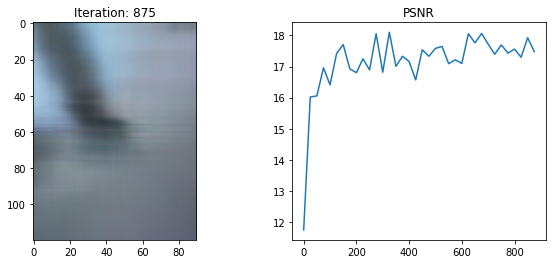

900 1.8694348621368408 secs per iter


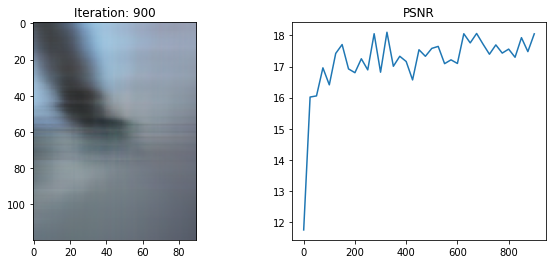

925 1.8699508476257325 secs per iter


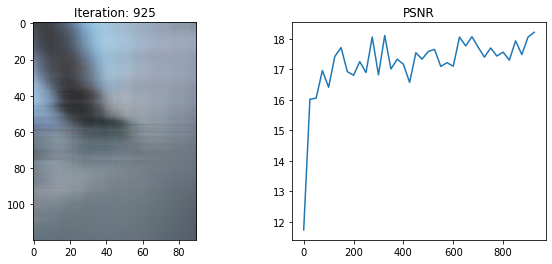

950 1.8665286445617675 secs per iter


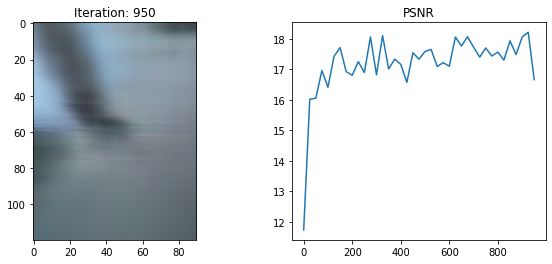

975 1.8681821823120117 secs per iter


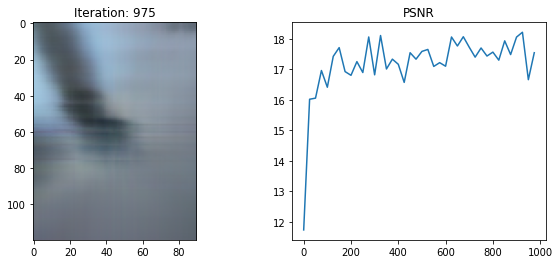

1000 1.8679703044891358 secs per iter


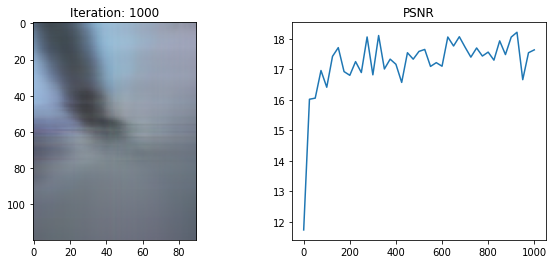

1025 1.867179412841797 secs per iter


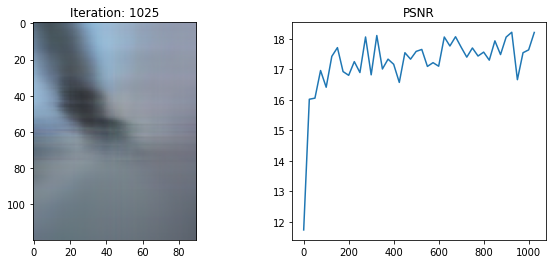

1050 1.8653461647033691 secs per iter


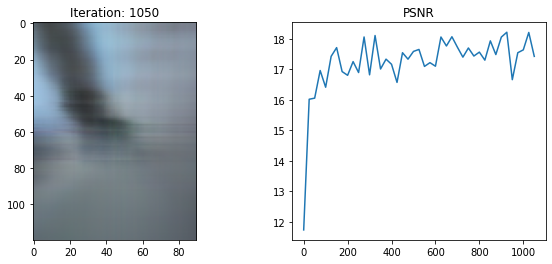

1075 1.8675920677185058 secs per iter


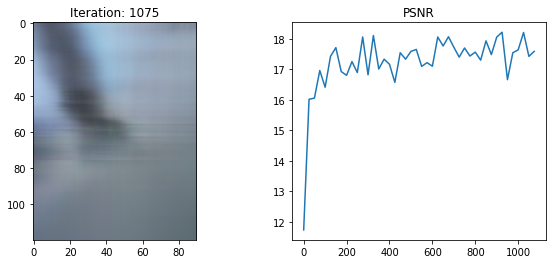

1100 1.866719093322754 secs per iter


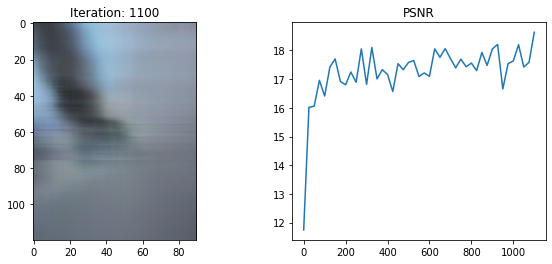

1125 1.8687740516662599 secs per iter


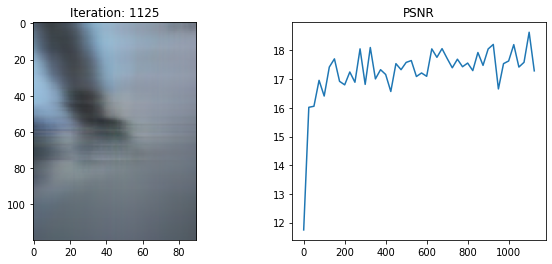

1150 1.8710853576660156 secs per iter


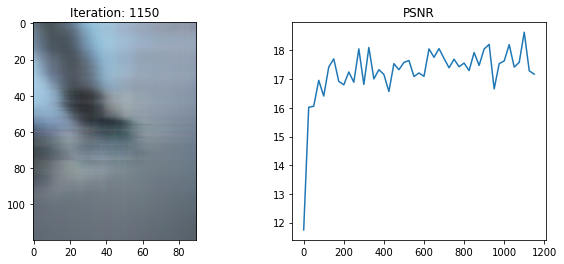

1175 1.8765423965454102 secs per iter


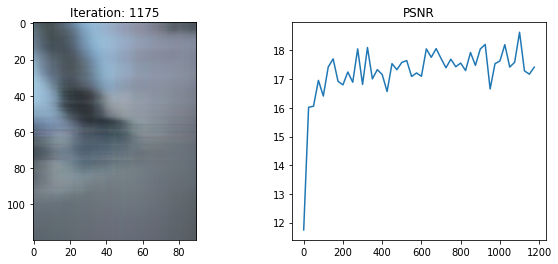

1200 1.8771210384368897 secs per iter


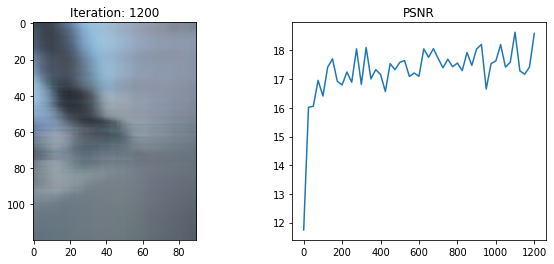

1225 1.8757443046569824 secs per iter


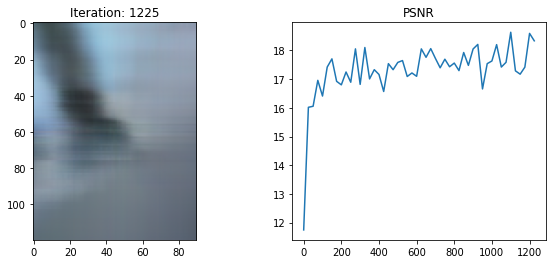

1250 1.8784941673278808 secs per iter


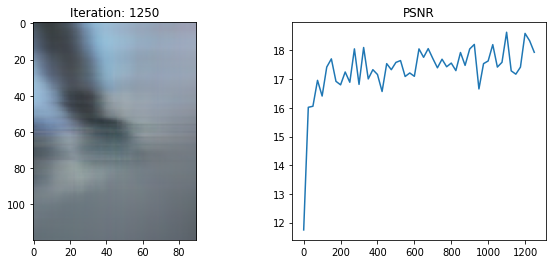

1275 1.8765771961212159 secs per iter


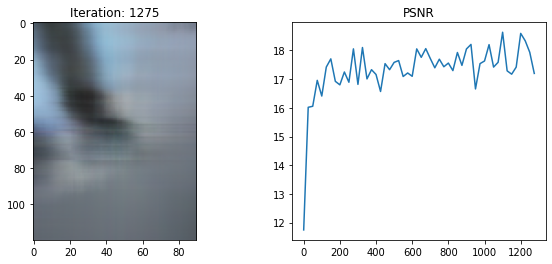

1300 1.8753812217712402 secs per iter


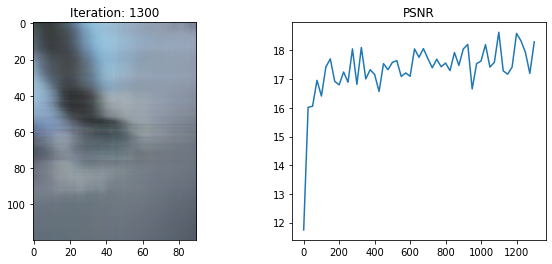

1325 1.8750239372253419 secs per iter


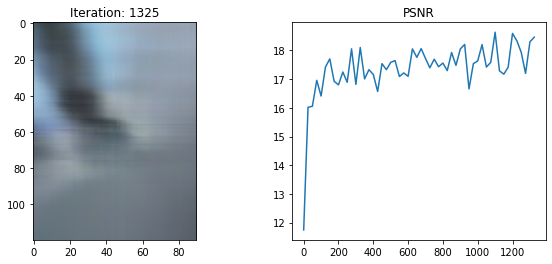

1350 1.8751600742340089 secs per iter


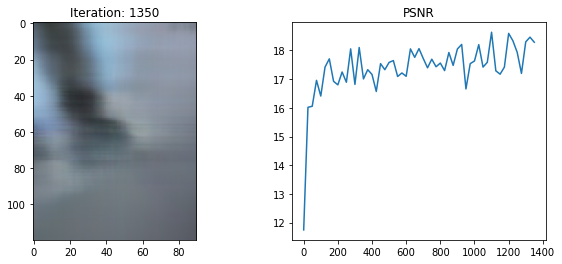

1375 1.8794665050506592 secs per iter


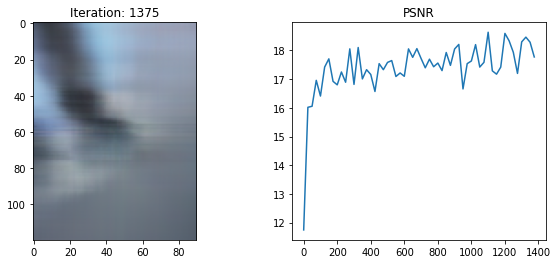

1400 1.8758531761169435 secs per iter


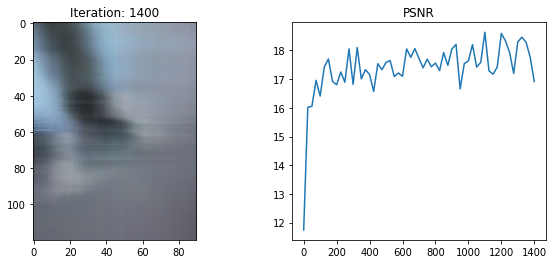

1425 1.8664474296569824 secs per iter


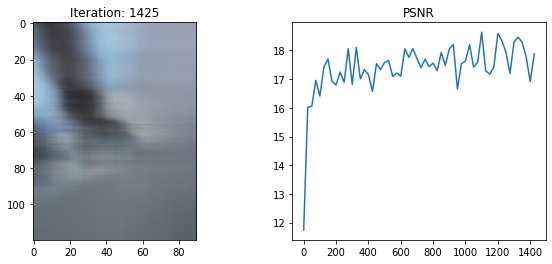

1450 1.8647543716430663 secs per iter


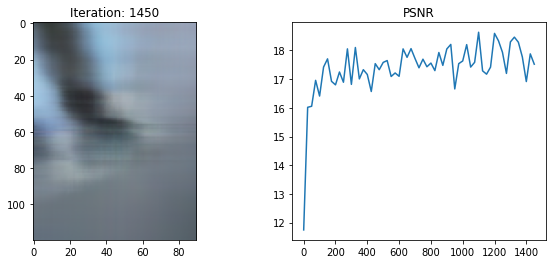

1475 1.8641786766052246 secs per iter


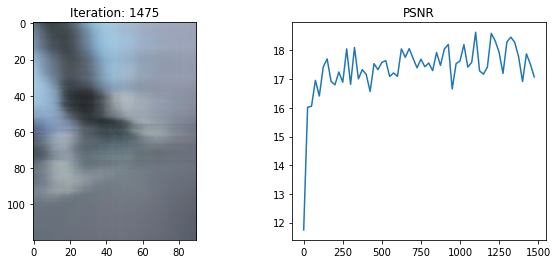

1500 1.864487829208374 secs per iter


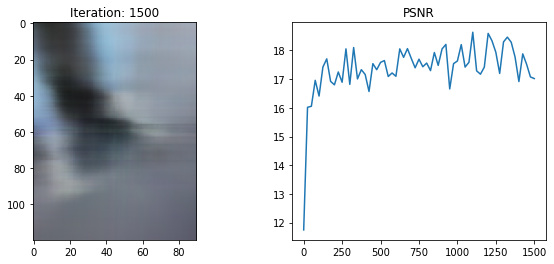

1525 1.8624708938598633 secs per iter


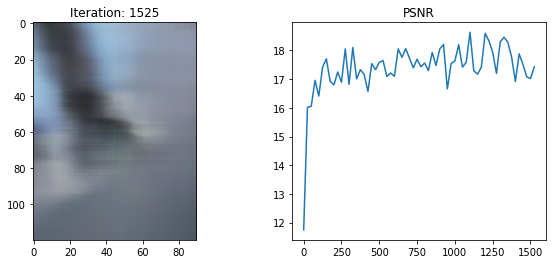

1550 1.8646417713165284 secs per iter


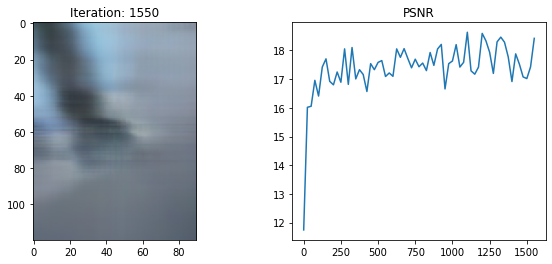

1575 1.8629902744293212 secs per iter


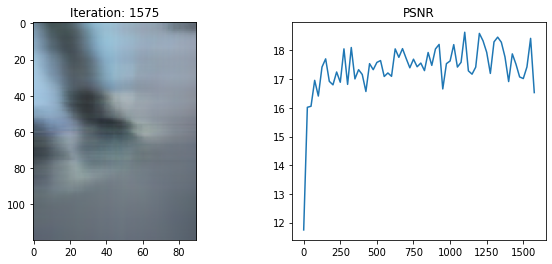

1600 1.863927354812622 secs per iter


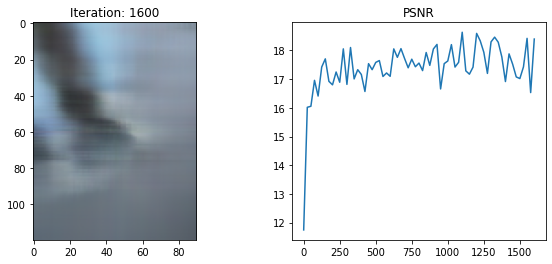

1625 1.8654499053955078 secs per iter


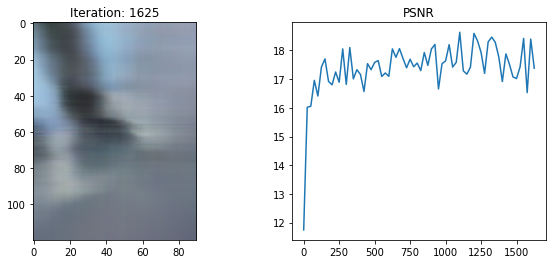

1650 1.8654389381408691 secs per iter


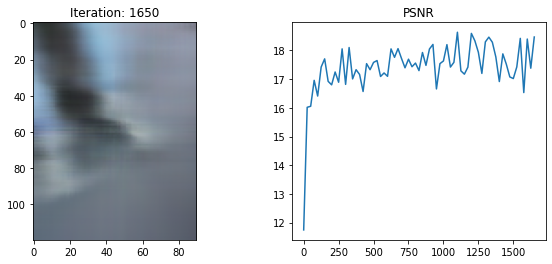

1675 1.8656884670257567 secs per iter


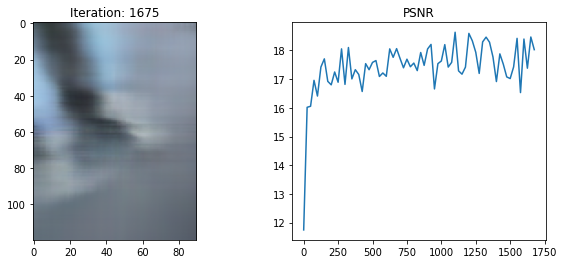

1700 1.8683238220214844 secs per iter


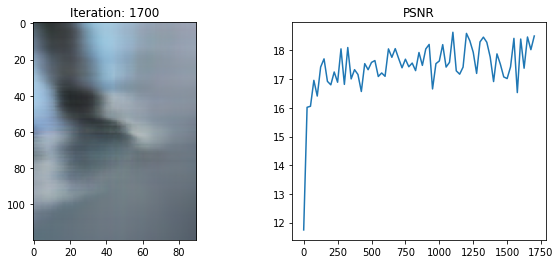

1725 1.865207748413086 secs per iter


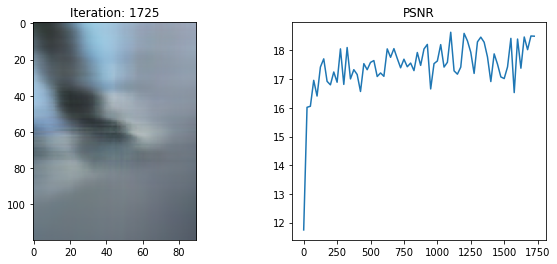

1750 1.870243377685547 secs per iter


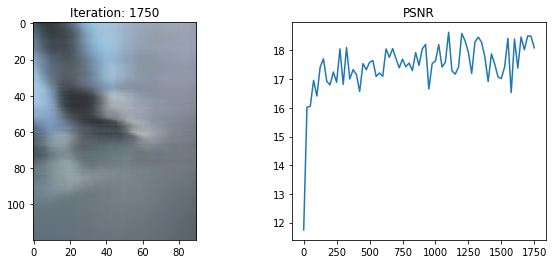

1775 1.867875108718872 secs per iter


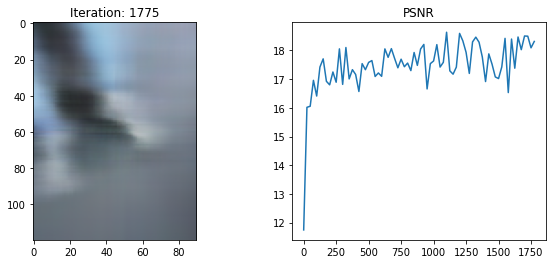

1800 1.862981882095337 secs per iter


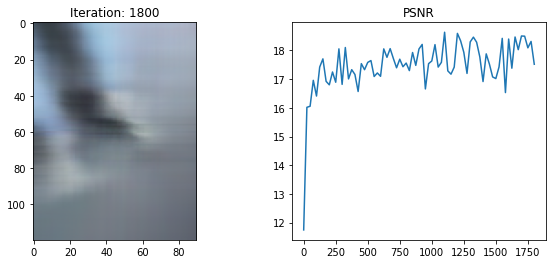

1825 1.8660962200164795 secs per iter


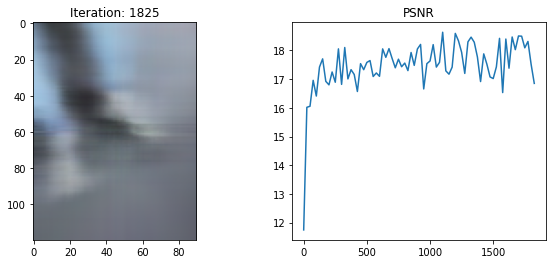

1850 1.8624339485168457 secs per iter


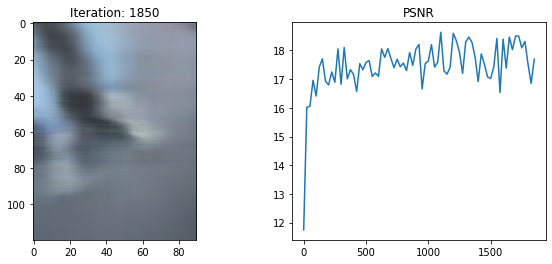

1875 1.8644924640655518 secs per iter


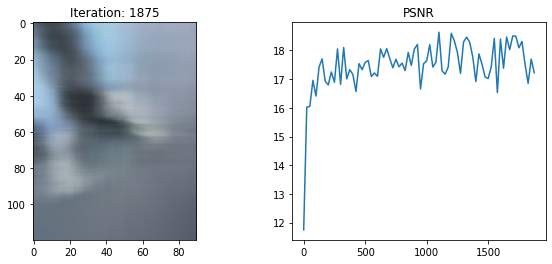

1900 1.859918508529663 secs per iter


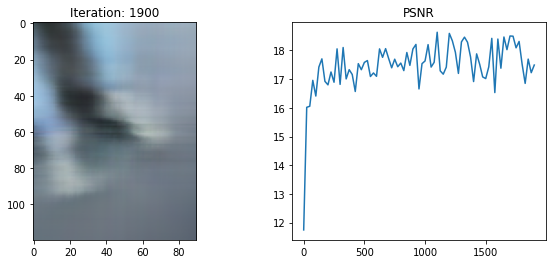

1925 1.8609553527832032 secs per iter


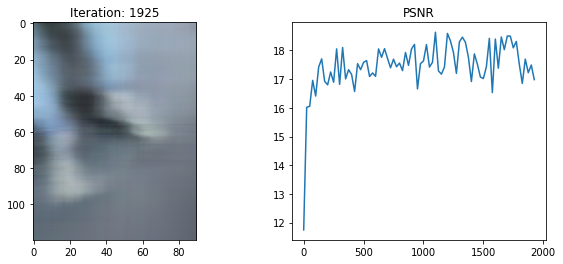

1950 1.8617678737640382 secs per iter


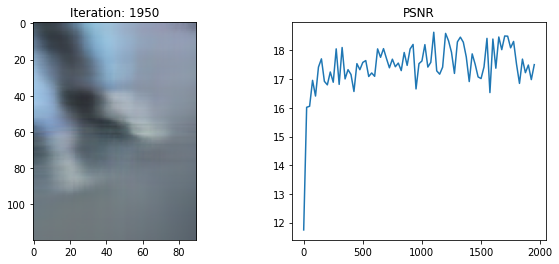

1975 1.8621337604522705 secs per iter


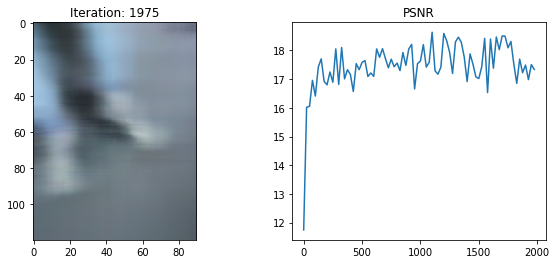

2000 1.8635202884674071 secs per iter


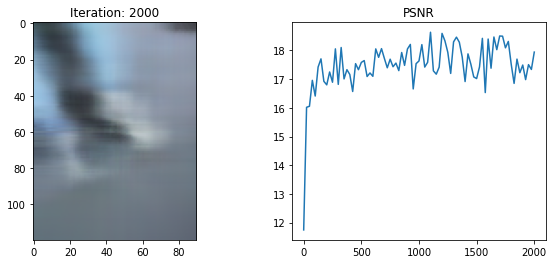

Done


In [ ]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 2000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)

    #rays_o=rays_o*10
    rays_o=np.float32(rays_o)
    rays_o=tf.convert_to_tensor(rays_o,dtype=tf.float32)

    #rays_d=rays_d*10
    rays_d=np.float32(rays_d)
    rays_d=tf.convert_to_tensor(rays_d,dtype=tf.float32)

    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)

        #rays_o=rays_o*10
        rays_o=np.float32(rays_o)
        rays_o=tf.convert_to_tensor(rays_o,dtype=tf.float32)

        #rays_d=rays_d*10
        rays_d=np.float32(rays_d)
        rays_d=tf.convert_to_tensor(rays_d,dtype=tf.float32)

        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')